In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
import warnings
warnings.filterwarnings('ignore')
import csv
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss, make_scorer, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.multiclass import OneVsRestClassifier

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/assignment1_colab/Telstra Case Study

/content/drive/MyDrive/assignment1_colab/Telstra Case Study


In [4]:
train_data = pd.read_csv('train.csv',index_col='id')
test_data = pd.read_csv('test.csv',index_col='id')
event_type = pd.read_csv('event_type.csv')
log_feature = pd.read_csv('log_feature.csv')
resource_type = pd.read_csv('resource_type.csv')
severity_type = pd.read_csv('severity_type.csv')

In [5]:
train_data_copy = train_data.copy()
test_data_copy = test_data.copy()
event_type_copy = event_type.copy()
log_feature_copy = log_feature.copy()
resource_type_copy = resource_type.copy()
severity_type_copy = severity_type.copy()

In [6]:
train_data = train_data.reset_index()
test_data = test_data.reset_index()

In [7]:
# append train & test
# ---------------------------------------------------------------------------------
train_data['location_id'] = train_data.location.apply(lambda x: int(x.split('location ')[1]))
test_data['location_id'] = test_data.location.apply(lambda x: int(x.split('location ')[1]))

print('train', train_data.shape, 'test', test_data.shape)

train (7381, 4) test (11171, 3)


**Approach-1 (BaseLine Model - OneHotEncoded + StdScaler())**

In [8]:
event_type['event_type'] = event_type['event_type'].map(lambda x: int(x.split(' ')[1]))
event_type = pd.get_dummies(event_type, columns=['event_type'],dtype=np.int64) # get dummy variables for event type
event_type = event_type.groupby(event_type.id,as_index=False).sum() # compact the rows with the same id

In [9]:
# 2.1. Left join training/test set <-> event_type set
X = pd.merge(left=train_data, right=event_type, how='left', left_on='id', right_on='id')
Y = pd.merge(left=test_data, right=event_type, how='left', left_on='id', right_on='id')

In [10]:
resource_type['resource_type'] = resource_type['resource_type'].map(lambda x: int(x.split(' ')[1]))
resource_type = pd.get_dummies(resource_type, columns=['resource_type'],dtype=np.int64)
resource_type = resource_type.groupby(resource_type.id,as_index=False).sum()

In [11]:
# 2.1. Left join training/test set <-> event_type set
X = pd.merge(left=X, right=resource_type, how='left', left_on='id', right_on='id')
Y = pd.merge(left=Y, right=resource_type, how='left', left_on='id', right_on='id')

In [12]:
print(X.shape,Y.shape)

(7381, 67) (11171, 66)


In [13]:
severity_type['severity_type'] = severity_type['severity_type'].map(lambda x: int(x.split(' ')[1]))
severity_type = pd.get_dummies(severity_type, columns=['severity_type'],dtype=np.int64)
severity_type = severity_type.groupby(severity_type.id,as_index=False).sum()

In [14]:
# 2.1. Left join training/test set <-> event_type set
X = pd.merge(left=X, right=severity_type, how='left', left_on='id', right_on='id')
Y = pd.merge(left=Y, right=severity_type, how='left', left_on='id', right_on='id')

In [15]:
print(X.shape,Y.shape)

(7381, 72) (11171, 71)


In [16]:
log_feature['log_feature'] = log_feature['log_feature'].map(lambda x: int(x.split(' ')[1]))
log_feature = pd.get_dummies(log_feature, columns=['log_feature'],dtype=np.int64)
log_feature = log_feature.groupby(log_feature.id,as_index=False).sum()

In [17]:
# 2.1. Left join training/test set <-> event_type set
X = pd.merge(left=X, right=log_feature, how='left', left_on='id', right_on='id')
Y = pd.merge(left=Y, right=log_feature, how='left', left_on='id', right_on='id')

In [18]:
print(X.shape,Y.shape)

(7381, 459) (11171, 458)


In [19]:
X.head(2)

,id,location,fault_severity,location_id,event_type_1,event_type_2,event_type_3,event_type_4,event_type_5,event_type_6,event_type_7,event_type_8,event_type_9,event_type_10,event_type_11,event_type_12,event_type_13,event_type_14,event_type_15,event_type_17,event_type_18,event_type_19,event_type_20,event_type_21,event_type_22,event_type_23,event_type_24,event_type_25,event_type_26,event_type_27,event_type_28,event_type_29,event_type_30,event_type_31,event_type_32,event_type_33,event_type_34,event_type_35,event_type_36,event_type_37,...,log_feature_347,log_feature_348,log_feature_349,log_feature_350,log_feature_351,log_feature_352,log_feature_353,log_feature_354,log_feature_355,log_feature_356,log_feature_357,log_feature_358,log_feature_359,log_feature_360,log_feature_361,log_feature_362,log_feature_363,log_feature_364,log_feature_365,log_feature_366,log_feature_367,log_feature_368,log_feature_369,log_feature_370,log_feature_371,log_feature_372,log_feature_373,log_feature_374,log_feature_375,log_feature_376,log_feature_377,log_feature_378,log_feature_379,log_feature_380,log_feature_381,log_feature_382,log_feature_383,log_feature_384,log_feature_385,log_feature_386
0,14121,location 118,1,118,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9320,location 91,0,91,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
X = X.drop('location',axis=1)
Y = Y.drop('location',axis=1)

In [21]:
X_df = X.copy()
Y_df = Y.copy()

In [22]:
X_df.dtypes

id                 int64
fault_severity     int64
location_id        int64
event_type_1       int64
event_type_2       int64
                   ...  
log_feature_382    int64
log_feature_383    int64
log_feature_384    int64
log_feature_385    int64
log_feature_386    int64
Length: 458, dtype: object

In [23]:
index = Y['id']
Y['id'] = index

In [24]:
X = X.set_index('id')
Y = Y.set_index('id')

In [25]:
X = X.drop(['fault_severity'], axis=1)
X.head(2)

,location_id,event_type_1,event_type_2,event_type_3,event_type_4,event_type_5,event_type_6,event_type_7,event_type_8,event_type_9,event_type_10,event_type_11,event_type_12,event_type_13,event_type_14,event_type_15,event_type_17,event_type_18,event_type_19,event_type_20,event_type_21,event_type_22,event_type_23,event_type_24,event_type_25,event_type_26,event_type_27,event_type_28,event_type_29,event_type_30,event_type_31,event_type_32,event_type_33,event_type_34,event_type_35,event_type_36,event_type_37,event_type_38,event_type_39,event_type_40,...,log_feature_347,log_feature_348,log_feature_349,log_feature_350,log_feature_351,log_feature_352,log_feature_353,log_feature_354,log_feature_355,log_feature_356,log_feature_357,log_feature_358,log_feature_359,log_feature_360,log_feature_361,log_feature_362,log_feature_363,log_feature_364,log_feature_365,log_feature_366,log_feature_367,log_feature_368,log_feature_369,log_feature_370,log_feature_371,log_feature_372,log_feature_373,log_feature_374,log_feature_375,log_feature_376,log_feature_377,log_feature_378,log_feature_379,log_feature_380,log_feature_381,log_feature_382,log_feature_383,log_feature_384,log_feature_385,log_feature_386
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
14121,118,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9320,91,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [26]:
y = X_df['fault_severity']

In [27]:
X.isnull().any()

location_id        False
event_type_1       False
event_type_2       False
event_type_3       False
event_type_4       False
                   ...  
log_feature_382    False
log_feature_383    False
log_feature_384    False
log_feature_385    False
log_feature_386    False
Length: 456, dtype: bool

**Test, Train and Cross Validation Split**

Splitting data into train, test (80:20)

In [28]:
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train,X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

In [29]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(5904, 456) (5904,) (1477, 456) (1477,)


In [30]:
print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])

Number of data points in train data: 5904
Number of data points in test data: 1477


In [31]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

In [32]:
# import the needed libraries first
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

# create a transformer for the categorical values
categorical_transformer = Pipeline(steps=[
    ('one_hot', OneHotEncoder(handle_unknown='ignore'))])

# create a transformed for the numerical values
numeric_transformer_std = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler',StandardScaler())])

In [33]:

from sklearn.compose import ColumnTransformer

preprocessor_sca_train = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_std, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [34]:
#We are then ready to transform!
X_train_transformed_sca = preprocessor_sca_train.fit_transform(X_train)
X_test_transformed_sca = preprocessor_sca_train.transform(X_test)
X_train_transformed_sca_copy = X_train_transformed_sca.copy()
test_transformed_sca = preprocessor_sca_train.transform(Y)

In [35]:
X_train_sca = pd.DataFrame(X_train_transformed_sca)
X_test_sca = pd.DataFrame(X_test_transformed_sca)
test_sca = pd.DataFrame(test_transformed_sca)

In [36]:
from sklearn.ensemble import GradientBoostingClassifier

In [37]:
classifiers = [KNeighborsClassifier(),
               RandomForestClassifier(),
               # Learn to predict each class against the other
               LogisticRegression(multi_class='ovr'),
               OneVsRestClassifier(SVC()),
               OneVsRestClassifier(XGBClassifier()),
               lgb.LGBMClassifier(),
               GradientBoostingClassifier()
              ]
classifier_names = ['kNN','forest','LogReg','SVC','XGB','LGBM','GBC']

In [ ]:
scoring = ['f1_macro','precision_macro', 'recall_macro']

In [ ]:
# Loop through classifiers
print('Model evaluation By Standardizing Data')

for classifier, clf_name in zip(classifiers, classifier_names):
  # Calculate CV
  print(clf_name,'\t',cross_val_score(estimator=classifier,X=X_train_sca, y=y_train, cv=5, scoring='f1_macro').mean())

Model evaluation By Standardizing Data
kNN 	 0.6005997148397582
forest 	 0.6344846989381515
LogReg 	 0.6210558076746047
SVC 	 0.6066614113462898
XGB 	 0.6145534222368054
LGBM 	 0.6490994199360033
GBC 	 0.6274849395900925


In [ ]:
from sklearn.metrics import classification_report

In [ ]:
# Train uncalibrated random forest classifier on whole train and validation
# data and evaluate on test data
lgbm = lgb.LGBMClassifier()
lgbm.fit(X_train_sca, y_train)

LGBMClassifier()

In [ ]:
#Predictions
y_pred = lgbm.predict(X_test_sca)
report1 = classification_report(y_test,y_pred,output_dict=True)
df_std = pd.DataFrame(report1).transpose()

In [ ]:
df_std

,precision,recall,f1-score,support
0,0.821179,0.858934,0.839632,957.00000
1,0.608025,0.525333,0.563662,375.00000
2,0.539474,0.565517,0.552189,145.00000
accuracy,0.745430,0.745430,0.745430,0.74543
macro avg,0.656226,0.649928,0.651828,1477.00000
weighted avg,0.739405,0.745430,0.741347,1477.00000


In [ ]:
from sklearn.metrics import log_loss

In [ ]:
y_test = pd.DataFrame(y_test)
y_train = pd.DataFrame(y_train)

In [ ]:
loss2tr = log_loss(y_train.values, lgbm.predict_proba(X_train_sca.values))
print("LGBM: train loss {:.4f}".format(loss2tr))
print('---------------------------------------------------------------')
loss2te = log_loss(y_test.values, lgbm.predict_proba(X_test_sca.values))
print("LGBM forest: test loss {:.4f}".format(loss2te))
print('---------------------------------------------------------------')

LGBM: train loss 0.4042
---------------------------------------------------------------
LGBM forest: test loss 0.5513
---------------------------------------------------------------


**Approach-2 (OneHotEncoded + StdScaler() +  PCA())**

In [ ]:
# Calculating Eigenvectors and eigenvalues of Cov matirx
mean_vec = np.mean(X_train_transformed_sca_copy, axis=0)
cov_mat = np.cov(X_train_transformed_sca_copy.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
# Create a list of (eigenvalue, eigenvector) tuples
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the eigenvalue, eigenvector pair from high to low
eig_pairs.sort(key = lambda x: x[0], reverse= True)

# Calculation of Explained Variance from the eigenvalues
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

In [ ]:
# Find the eigenvector beyond which 85% of the data is explained
[ n for n,i in enumerate(cum_var_exp) if i>85 ][0]

136

In [ ]:
from sklearn.decomposition import PCA

# Call the PCA method with 134 components. 
pca = PCA(n_components=134)
pca.fit(X_train_transformed_sca)
X_134d_train = pca.transform(X_train_transformed_sca)
X_134d_test = pca.transform(X_test_transformed_sca)

In [ ]:
print(X_134d_train.shape,y_train.shape)

(5904, 134) (5904, 1)


In [ ]:
lgbm = lgb.LGBMClassifier()
lgbm.fit(X_134d_train, y_train)

LGBMClassifier()

In [ ]:
print(y_test.shape,y_pred.shape)

(1477, 1) (1477,)


In [ ]:
#Predictions
y_pred = lgbm.predict(X_134d_test)
report2 = classification_report(y_test,y_pred,output_dict=True)
df_std = pd.DataFrame(report2).transpose()

In [ ]:
df_std

,precision,recall,f1-score,support
0,0.817279,0.859979,0.838086,957.000000
1,0.557229,0.493333,0.523338,375.000000
2,0.514493,0.489655,0.501767,145.000000
accuracy,0.730535,0.730535,0.730535,0.730535
macro avg,0.629667,0.614323,0.621063,1477.000000
weighted avg,0.721529,0.730535,0.725156,1477.000000


In [ ]:
X_134d_train = pd.DataFrame(X_134d_train)
X_134d_test = pd.DataFrame(X_134d_test)

In [ ]:
loss2tr = log_loss(y_train.values, lgbm.predict_proba(X_134d_train.values))
print("Random forest: train loss {:.4f}".format(loss2tr))
print('---------------------------------------------------------------')
loss2te = log_loss(y_test.values, lgbm.predict_proba(X_134d_test.values))
print("Random forest: test loss {:.4f}".format(loss2te))
print('---------------------------------------------------------------')

Random forest: train loss 0.3024
---------------------------------------------------------------
Random forest: test loss 0.5797
---------------------------------------------------------------


**OneHptEncodng + MinMaxScaler**

In [ ]:
# create a transformed for the numerical values
numeric_transformer_minmax = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler',MinMaxScaler())])

In [ ]:
from sklearn.compose import ColumnTransformer

preprocessor_sca_minmax = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_minmax, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [ ]:
#We are then ready to transform!
X_train_transformed_sca = preprocessor_sca_minmax.fit_transform(X_train)
X_test_transformed_sca = preprocessor_sca_minmax.transform(X_test)
X_train_transformed_sca_copy = X_train_transformed_sca.copy()
test_transformed_sca = preprocessor_sca_minmax.transform(Y)

In [ ]:
X_train_sca = pd.DataFrame(X_train_transformed_sca)
X_test_sca = pd.DataFrame(X_test_transformed_sca)
test_sca = pd.DataFrame(test_transformed_sca)

In [ ]:
# Loop through classifiers
print('Model evaluation By Standardizing Data')

for classifier, clf_name in zip(classifiers, classifier_names):
  # Calculate CV
  print(clf_name,'\t',cross_val_score(estimator=classifier,X=X_train_sca, y=y_train, cv=5, scoring='f1_macro').mean())

Model evaluation By Standardizing Data
kNN 	 0.5859140300977853
forest 	 0.6308603582242089
LogReg 	 0.589781459093239
SVC 	 0.5966931479525635
XGB 	 0.6145534222368054
LGBM 	 0.6530227324218197
GBC 	 0.628346428839474


In [ ]:
# Train uncalibrated random forest classifier on whole train and validation
# data and evaluate on test data
lbbm = lgb.LGBMClassifier()
lgbm.fit(X_train_sca, y_train)

LGBMClassifier()

In [ ]:
#Predictions
y_pred = lgbm.predict(X_test_sca)
report3 = classification_report(y_test,y_pred,output_dict=True)
df_std = pd.DataFrame(report3).transpose()

In [ ]:
df_std

,precision,recall,f1-score,support
0,0.830645,0.861024,0.845562,957.0000
1,0.615616,0.546667,0.579096,375.0000
2,0.539474,0.565517,0.552189,145.0000
accuracy,0.752200,0.752200,0.752200,0.7522
macro avg,0.661911,0.657736,0.658949,1477.0000
weighted avg,0.747466,0.752200,0.749107,1477.0000


In [ ]:
loss2tr = log_loss(y_train.values, lgbm.predict_proba(X_train_sca.values))
print("Random forest: train loss {:.4f}".format(loss2tr))
print('---------------------------------------------------------------')
loss2te = log_loss(y_test.values, lgbm.predict_proba(X_test_sca.values))
print("Random forest: test loss {:.4f}".format(loss2te))
print('---------------------------------------------------------------')

Random forest: train loss 0.4047
---------------------------------------------------------------
Random forest: test loss 0.5442
---------------------------------------------------------------


**OneHptEncodng + MinMaxScaler + PCA()**

In [ ]:
# Calculating Eigenvectors and eigenvalues of Cov matirx
mean_vec = np.mean(X_train_transformed_sca_copy, axis=0)
cov_mat = np.cov(X_train_transformed_sca_copy.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
# Create a list of (eigenvalue, eigenvector) tuples
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the eigenvalue, eigenvector pair from high to low
eig_pairs.sort(key = lambda x: x[0], reverse= True)

# Calculation of Explained Variance from the eigenvalues
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

# Find the eigenvector beyond which 90% of the data is explained
[ n for n,i in enumerate(cum_var_exp) if i>90 ][0]

38

In [ ]:
from sklearn.decomposition import PCA

# Call the PCA method with 38 components. 
pca = PCA(n_components=38)
pca.fit(X_train_transformed_sca)
X_38d_train = pca.transform(X_train_transformed_sca)
X_38d_test = pca.transform(X_test_transformed_sca)

In [ ]:
print(X_38d_train.shape,y_train.shape)

(5904, 38) (5904, 1)


In [ ]:
lbbm = lgb.LGBMClassifier()
lgbm.fit(X_38d_train, y_train)

LGBMClassifier()

In [ ]:
#Predictions
y_pred = lgbm.predict(X_38d_test)
report4 = classification_report(y_test,y_pred,output_dict=True)
df_std = pd.DataFrame(report4).transpose()

In [ ]:
df_std

,precision,recall,f1-score,support
0,0.819192,0.847440,0.833077,957.00000
1,0.543860,0.496000,0.518828,375.00000
2,0.482759,0.482759,0.482759,145.00000
accuracy,0.722410,0.722410,0.722410,0.72241
macro avg,0.615270,0.608733,0.611555,1477.00000
weighted avg,0.716259,0.722410,0.718900,1477.00000


In [ ]:
X_38d_train = pd.DataFrame(X_38d_train)
X_38d_test = pd.DataFrame(X_38d_test)

In [ ]:
loss2tr = log_loss(y_train.values, lgbm.predict_proba(X_38d_train.values))
print("Random forest: train loss {:.4f}".format(loss2tr))
print('---------------------------------------------------------------')
loss2te = log_loss(y_test.values, lgbm.predict_proba(X_38d_test.values))
print("Random forest: test loss {:.4f}".format(loss2te))
print('---------------------------------------------------------------')

Random forest: train loss 0.3670
---------------------------------------------------------------
Random forest: test loss 0.6017
---------------------------------------------------------------


**OneHoEncoding + RobustScaler()**

In [ ]:
# create a transformed for the numerical values
numeric_transformer_robust = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler',RobustScaler())])

In [ ]:
from sklearn.compose import ColumnTransformer

preprocessor_sca_robust = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_robust, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [ ]:
#We are then ready to transform!
X_train_transformed_sca = preprocessor_sca_robust.fit_transform(X_train)
X_test_transformed_sca = preprocessor_sca_robust.transform(X_test)
X_train_transformed_sca_copy = X_train_transformed_sca.copy()
test_transformed_sca = preprocessor_sca_robust.transform(Y)

X_train_sca = pd.DataFrame(X_train_transformed_sca)
X_test_sca = pd.DataFrame(X_test_transformed_sca)
test_sca = pd.DataFrame(test_transformed_sca)

In [ ]:
# Loop through classifiers
print('Model evaluation By Standardizing Data')

for classifier, clf_name in zip(classifiers, classifier_names):
  # Calculate CV
  print(clf_name,'\t',cross_val_score(estimator=classifier,X=X_train_sca, y=y_train, cv=5, scoring='f1_macro').mean())

Model evaluation By Standardizing Data
kNN 	 0.5944700220651774
forest 	 0.6333380866880441
LogReg 	 0.6106504108167008
SVC 	 0.6069384796365953
XGB 	 0.6145534222368054
LGBM 	 0.647369724903187
GBC 	 0.6268064348967959


In [ ]:
# Train uncalibrated random forest classifier on whole train and validation
# data and evaluate on test data
lbbm = lgb.LGBMClassifier()
lgbm.fit(X_train_sca, y_train)

LGBMClassifier()

In [ ]:
#Predictions
y_pred = lgbm.predict(X_test_sca)
report5 = classification_report(y_test,y_pred,output_dict=True)
df_std = pd.DataFrame(report5).transpose()

In [ ]:
df_std

,precision,recall,f1-score,support
0,0.823353,0.862069,0.842266,957.000000
1,0.610592,0.522667,0.563218,375.000000
2,0.538961,0.572414,0.555184,145.000000
accuracy,0.747461,0.747461,0.747461,0.747461
macro avg,0.657635,0.652383,0.653556,1477.000000
weighted avg,0.741415,0.747461,0.743235,1477.000000


In [ ]:
loss2tr = log_loss(y_train.values, lgbm.predict_proba(X_train.values))
print("Random forest: train loss {:.4f}".format(loss2tr))
print('---------------------------------------------------------------')
loss2te = log_loss(y_test.values, lgbm.predict_proba(X_test.values))
print("Random forest: test loss {:.4f}".format(loss2te))
print('---------------------------------------------------------------')

Random forest: train loss 0.8647
---------------------------------------------------------------
Random forest: test loss 0.9167
---------------------------------------------------------------


**Approach-3 -- OneHotEncoder + MinMaxScaler() + Adding new features**

a) Adding log volume features

In [38]:
# merge log features
log_vol = log_feature_copy.groupby('id')['volume'].agg(['count','min', 'mean', 'max', 'std', 'sum']).fillna(0).add_prefix('log_volume')

In [39]:
log_vol = log_vol.reset_index()

In [40]:
log_vol.head(2)

,id,log_volumecount,log_volumemin,log_volumemean,log_volumemax,log_volumestd,log_volumesum
0,1,3,1,1.666667,2,0.57735,5
1,2,5,1,1.000000,1,0.00000,5


In [41]:
print(X.shape,Y.shape)

(7381, 456) (11171, 456)


In [42]:
X.head(1)

,location_id,event_type_1,event_type_2,event_type_3,event_type_4,event_type_5,event_type_6,event_type_7,event_type_8,event_type_9,event_type_10,event_type_11,event_type_12,event_type_13,event_type_14,event_type_15,event_type_17,event_type_18,event_type_19,event_type_20,event_type_21,event_type_22,event_type_23,event_type_24,event_type_25,event_type_26,event_type_27,event_type_28,event_type_29,event_type_30,event_type_31,event_type_32,event_type_33,event_type_34,event_type_35,event_type_36,event_type_37,event_type_38,event_type_39,event_type_40,...,log_feature_347,log_feature_348,log_feature_349,log_feature_350,log_feature_351,log_feature_352,log_feature_353,log_feature_354,log_feature_355,log_feature_356,log_feature_357,log_feature_358,log_feature_359,log_feature_360,log_feature_361,log_feature_362,log_feature_363,log_feature_364,log_feature_365,log_feature_366,log_feature_367,log_feature_368,log_feature_369,log_feature_370,log_feature_371,log_feature_372,log_feature_373,log_feature_374,log_feature_375,log_feature_376,log_feature_377,log_feature_378,log_feature_379,log_feature_380,log_feature_381,log_feature_382,log_feature_383,log_feature_384,log_feature_385,log_feature_386
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
14121,118,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [43]:
# 2.1. Left join training/test set <-> event_type set
X = pd.merge(left=X, right=log_vol, how='left', left_on='id', right_on='id')
Y = pd.merge(left=Y, right=log_vol, how='left', left_on='id', right_on='id')

In [44]:
print(X.shape,Y.shape)

(7381, 463) (11171, 463)


b)Merging severity type, event type and log feature on 'id' and creaing new feature using location id's

In [45]:
X1 = pd.merge(left=train_data_copy, right=event_type_copy, how='left', left_on='id', right_on='id')
Y1 = pd.merge(left=test_data_copy, right=event_type_copy, how='left', left_on='id', right_on='id')

In [46]:
X1 = pd.merge(left=X1, right=log_feature_copy, how='left', left_on='id', right_on='id')
Y1 = pd.merge(left=Y1, right=log_feature_copy, how='left', left_on='id', right_on='id')

In [47]:
X1.head(2)

,id,location,fault_severity,event_type,log_feature,volume
0,14121,location 118,1,event_type 34,feature 312,19
1,14121,location 118,1,event_type 34,feature 232,19


In [48]:
# merge log features
events = X1.groupby('id')['volume'].agg(['count','min', 'mean', 'max','sum']).fillna(0).add_prefix('event_vol')

In [49]:
events = events.reset_index()

In [50]:
# 2.1. Left join training/test set <-> event_type set
X = pd.merge(left=X, right=events, how='left', left_on='id', right_on='id')
Y = pd.merge(left=Y, right=events, how='left', left_on='id', right_on='id')

In [51]:
X1 = pd.merge(left=X1, right=severity_type_copy, how='left', left_on='id', right_on='id')
Y1 = pd.merge(left=Y1, right=severity_type_copy, how='left', left_on='id', right_on='id')

In [52]:
# merge log features
severity = X1.groupby('id')['volume'].agg(['count','min', 'mean', 'max','sum']).fillna(0).add_prefix('sev_vol')

In [53]:
severity  = severity.reset_index()

In [54]:
# 2.1. Left join training/test set <-> event_type set
X = pd.merge(left=X, right=severity, how='left', left_on='id', right_on='id')
Y = pd.merge(left=Y, right=severity, how='left', left_on='id', right_on='id')

In [55]:
print(X.shape,Y.shape)

(7381, 473) (11171, 473)


c) Adding new 'location_id' feature

In [56]:
#newly added
X1['location_id'] = X1.location.apply(lambda x: int(x.split('location ')[1]))
Y1['location_id'] = Y1.location.apply(lambda x: int(x.split('location ')[1]))

In [57]:
"""

X["avgev_per_loc"]= X1.groupby(['event_type'])["volume"].transform('mean')
X["maxev_per_loc"]= X1.groupby(['event_type'])["volume"].transform('max')
X["minev_per_event"]= X1.groupby(['event_type'])["volume"].transform('min')
X["noev_per_event"]= X1.groupby(['event_type'])["volume"].transform('count')

Y["avgev_per_loc"]= Y1.groupby(['event_type'])["volume"].transform('mean')
Y["maxev_per_loc"]= Y1.groupby(['event_type'])["volume"].transform('max')
Y["minev_per_event"]= Y1.groupby(['event_type'])["volume"].transform('min')
Y["noev_per_event"]= Y1.groupby(['event_type'])["volume"].transform('count')


"""

'\n\nX["avgev_per_loc"]= X1.groupby([\'event_type\'])["volume"].transform(\'mean\')\nX["maxev_per_loc"]= X1.groupby([\'event_type\'])["volume"].transform(\'max\')\nX["minev_per_event"]= X1.groupby([\'event_type\'])["volume"].transform(\'min\')\nX["noev_per_event"]= X1.groupby([\'event_type\'])["volume"].transform(\'count\')\n\nY["avgev_per_loc"]= Y1.groupby([\'event_type\'])["volume"].transform(\'mean\')\nY["maxev_per_loc"]= Y1.groupby([\'event_type\'])["volume"].transform(\'max\')\nY["minev_per_event"]= Y1.groupby([\'event_type\'])["volume"].transform(\'min\')\nY["noev_per_event"]= Y1.groupby([\'event_type\'])["volume"].transform(\'count\')\n\n\n'

In [58]:
"""
X["avgres_per_loc"]= X1.groupby(['resource_type'])["volume"].transform('mean')
X["maxres_per_loc"]= X1.groupby(['resource_type'])["volume"].transform('max')
X["minres_per_loc"]= X1.groupby(['resource_type'])["volume"].transform('min')
X["rescount_per_loc"]= X1.groupby(['resource_type'])["volume"].transform('count')

Y["avgres_per_loc"]= Y1.groupby(['resource_type'])["volume"].transform('mean')
Y["maxres_per_loc"]= Y1.groupby(['resource_type'])["volume"].transform('max')
Y["minres_per_loc"]= Y1.groupby(['resource_type'])["volume"].transform('min')
Y["rescount_per_loc"]= Y1.groupby(['resource_type'])["volume"].transform('count')

"""

'\nX["avgres_per_loc"]= X1.groupby([\'resource_type\'])["volume"].transform(\'mean\')\nX["maxres_per_loc"]= X1.groupby([\'resource_type\'])["volume"].transform(\'max\')\nX["minres_per_loc"]= X1.groupby([\'resource_type\'])["volume"].transform(\'min\')\nX["rescount_per_loc"]= X1.groupby([\'resource_type\'])["volume"].transform(\'count\')\n\nY["avgres_per_loc"]= Y1.groupby([\'resource_type\'])["volume"].transform(\'mean\')\nY["maxres_per_loc"]= Y1.groupby([\'resource_type\'])["volume"].transform(\'max\')\nY["minres_per_loc"]= Y1.groupby([\'resource_type\'])["volume"].transform(\'min\')\nY["rescount_per_loc"]= Y1.groupby([\'resource_type\'])["volume"].transform(\'count\')\n\n'

In [59]:
"""
X["avgsev_per_loc"]= X1.groupby(['severity_type'])["volume"].transform('mean')
X["maxsev_per_loc"]= X1.groupby(['severity_type'])["volume"].transform('max')
X["minsev_per_loc"]= X1.groupby(['severity_type'])["volume"].transform('min')

Y["avgsev_per_loc"]= Y1.groupby(['severity_type'])["volume"].transform('mean')
Y["maxsev_per_loc"]= Y1.groupby(['severity_type'])["volume"].transform('max')
Y["minsev_per_loc"]= Y1.groupby(['severity_type'])["volume"].transform('min')
"""

'\nX["avgsev_per_loc"]= X1.groupby([\'severity_type\'])["volume"].transform(\'mean\')\nX["maxsev_per_loc"]= X1.groupby([\'severity_type\'])["volume"].transform(\'max\')\nX["minsev_per_loc"]= X1.groupby([\'severity_type\'])["volume"].transform(\'min\')\n\nY["avgsev_per_loc"]= Y1.groupby([\'severity_type\'])["volume"].transform(\'mean\')\nY["maxsev_per_loc"]= Y1.groupby([\'severity_type\'])["volume"].transform(\'max\')\nY["minsev_per_loc"]= Y1.groupby([\'severity_type\'])["volume"].transform(\'min\')\n'

d)Inserting new feature 'log_volume'

In [60]:
# Python log transform
X.insert(len(X.columns), 'log_volume',np.log(X['volume']))
Y.insert(len(Y.columns), 'log_volume',np.log(Y['volume']))

e) adding avg,min,max,median,std volume of traffic using location_id by using groupby opeartion. 

In [61]:
X["avgvol_per_loc"]= X1.groupby(['location_id'])["volume"].transform('mean')
X["maxvol_per_loc"]= X1.groupby(['location_id'])["volume"].transform('max')
X["minvol_per_loc"]= X1.groupby(['location_id'])["volume"].transform('min')
X["medianvol_per_loc"]= X1.groupby(['location_id'])["volume"].transform('median')
X["stdvol_per_loc"] = X1.groupby(['location_id'])["volume"].transform('std')

Y["avgvol_per_loc"]= Y1.groupby(['location_id'])["volume"].transform('mean')
Y["maxvol_per_loc"]= Y1.groupby(['location_id'])["volume"].transform('max')
Y["minvol_per_loc"]= Y1.groupby(['location_id'])["volume"].transform('min')
Y["medianvol_per_loc"]= Y1.groupby(['location_id'])["volume"].transform('median')
Y["stdvol_per_loc"] = Y1.groupby(['location_id'])["volume"].transform('std')

In [62]:
print(X.shape,Y.shape)

(7381, 479) (11171, 479)


In [63]:
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train,X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

In [64]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(5904, 479) (5904,) (1477, 479) (1477,)


In [65]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

In [66]:
# create a transformed for the numerical values
numeric_transformer_minmax = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler',MinMaxScaler())])

from sklearn.compose import ColumnTransformer

preprocessor_sca_minmax = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_minmax, numeric_features),
        #('cat', categorical_transformer, categorical_features)
    ])

In [67]:
#We are then ready to transform!
X_train_transformed_sca1 = preprocessor_sca_minmax.fit_transform(X_train)
X_test_transformed_sca1 = preprocessor_sca_minmax.transform(X_test)
X_train_transformed_sca_copy = X_train_transformed_sca.copy()
test_transformed_sca1 = preprocessor_sca_minmax.transform(Y)

X_train_sca = pd.DataFrame(X_train_transformed_sca1)
X_test_sca = pd.DataFrame(X_test_transformed_sca1)
test_sca = pd.DataFrame(test_transformed_sca1)

In [68]:
X_train_sca.shape

(5904, 479)

In [69]:
classifiers = [KNeighborsClassifier(),
               RandomForestClassifier(),
               # Learn to predict each class against the other
               LogisticRegression(multi_class='ovr'),
               OneVsRestClassifier(SVC()),
               OneVsRestClassifier(XGBClassifier()),
               lgb.LGBMClassifier()
              ]
classifier_names = ['kNN','forest','LogReg','SVC','XGB','LGBM']

In [70]:
# Loop through classifiers
print('Model evaluation By Standardizing Data')

for classifier, clf_name in zip(classifiers, classifier_names):
  # Calculate CV
  print(clf_name,'\t',cross_val_score(estimator=classifier,X=X_train_sca, y=y_train, cv=5, scoring='f1_macro').mean())

Model evaluation By Standardizing Data
kNN 	 0.5618026244241293
forest 	 0.6481718957962154
LogReg 	 0.628068415335632
SVC 	 0.6201487453356588
XGB 	 0.6340036680304983
LGBM 	 0.6593240251874732


In [71]:
# Train uncalibrated random forest classifier on whole train and validation
# data and evaluate on test data
lgbm = lgb.LGBMClassifier()
lgbm.fit(X_train_sca, y_train)

LGBMClassifier()

In [72]:
#Predictions
y_pred = lgbm.predict(X_test_sca)
report6 = classification_report(y_test,y_pred,output_dict=True)
df_std = pd.DataFrame(report6).transpose()

In [73]:
df_std

,precision,recall,f1-score,support
0,0.819688,0.878788,0.848210,957.000000
1,0.630573,0.528000,0.574746,375.000000
2,0.605839,0.572414,0.588652,145.000000
accuracy,0.759648,0.759648,0.759648,0.759648
macro avg,0.685367,0.659734,0.670536,1477.000000
weighted avg,0.750679,0.759648,0.753298,1477.000000


In [ ]:
y_test = pd.DataFrame(y_test)
y_train = pd.DataFrame(y_train)

In [ ]:
print(X_train_sca.shape,y_train.shape)

(5904, 474) (5904, 1)


In [ ]:
loss2tr = log_loss(y_train.values, lgbm.predict_proba(X_train_sca.values))
print("Random forest: train loss {:.4f}".format(loss2tr))
print('---------------------------------------------------------------')
loss2te = log_loss(y_test.values, lgbm.predict_proba(X_test_sca.values))
print("Random forest: test loss {:.4f}".format(loss2te))
print('---------------------------------------------------------------')

Random forest: train loss 0.3314
---------------------------------------------------------------
Random forest: test loss 0.5287
---------------------------------------------------------------


**Feature Importance**

In [ ]:
features=[]
for columns in X.columns:
    features.append(columns)

In [ ]:
imp_features = lgbm.feature_importances_
for i in imp_features:
    print(i.round(3))
df_imp_features = pd.DataFrame({"features":features}).join(pd.DataFrame({"weights":imp_features}))
df_imp_features = df_imp_features.sort_values(by=['weights'], ascending=False)

1326
1558
0
0
0
0
0
0
0
0
0
9
56
0
25
20
69
0
31
0
52
32
5
5
0
0
23
0
0
0
17
0
0
0
39
78
0
0
0
0
0
0
0
3
0
0
0
0
0
0
14
0
0
0
69
29
92
0
0
0
0
24
56
23
0
98
34
0
67
5
517
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
0
0
0
0
21
0
0
18
0
0
0
34
0
0
49
27
19
0
0
0
0
0
28
0
0
0
0
0
54
0
47
76
0
110
21
45
0
0
0
0
26
14
62
0
0
0
0
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
16
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
12
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
11
0
0
0
9
0
0
88
32
2
0
0
0
0
0
0
13
0
0
32
0
0
0
0
0
0
0
0
22
0
59
0
9
0
2
11
0
0
20
10
91
9
0
0
0
0
27
0
7
0
0
0
0
0
0
0
26
0
25
23
43
0
0
0
11
5
16
18
0
38
21
15
11
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
12
0
0
0
0
0
0
0
0
0
3
0
0
0
0
0
23
0
26
0
0
0
0
0
0
0
0
0
7
0
0
0
5
11
11
3
3
2
0
37
20
6
39
13
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
1
0
1
0
0
0
0
0
0
0
0
0
0
354
27

In [ ]:
df_imp_features = df_imp_features.head(10)

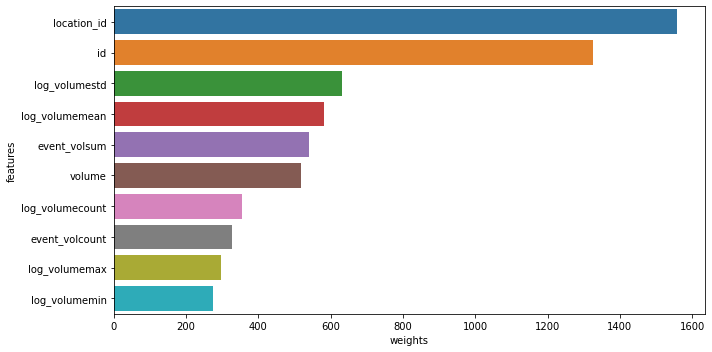

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x="weights",y="features",data=df_imp_features)
plt.tight_layout()
plt.savefig('lgbm_importances1.png')

In [142]:
y

0       1
1       0
2       1
3       1
4       0
       ..
7376    0
7377    0
7378    2
7379    0
7380    0
Name: fault_severity, Length: 7381, dtype: int64

In [144]:
y2 = y.astype(np.uint8)
n_classes = len(set(y2))

In [146]:
y_scores = lgbm.predict_proba(X_test_sca)

In [151]:
X_test_sca.shape

(1477, 479)

In [150]:
y_scores.size

4431

In [148]:
y_test

4131    0
6928    0
893     1
3214    0
5550    0
       ..
5302    0
6291    0
1436    0
2582    0
2418    0
Name: fault_severity, Length: 1477, dtype: int64

In [149]:
from sklearn.metrics import precision_recall_curve, roc_curve

In [ ]:
# precision recall curve
precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

**Hyperparamater Tuning Using Hyperopt - LGBM Classifier** 

sorce:https://www.kaggle.com/eikedehling/tune-and-compare-xgb-lightgbm-rf-with-hyperopt

In [ ]:
import lightgbm as lgbm

In [ ]:
def objective(params):
    params = {
        'objective': 'multiclass',
        'num_leaves': int(params['num_leaves']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
    }
    
    clf = lgbm.LGBMClassifier(
        n_estimators=500,
        learning_rate=0.005,
        max_depth=-1,
        **params
    )

    score = cross_val_score(clf, X_train_sca,y_train, scoring='f1_macro', cv=StratifiedKFold()).mean()
    print("F1 macro {:.3f} params {}".format(score, params))
    return score

space = {
    'num_leaves': hp.quniform('num_leaves', 8, 128, 2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=15)

F1 macro 0.636 params {'objective': 'multiclass', 'num_leaves': 100, 'colsample_bytree': '0.925'}
F1 macro 0.641 params {'objective': 'multiclass', 'num_leaves': 110, 'colsample_bytree': '0.588'}
F1 macro 0.643 params {'objective': 'multiclass', 'num_leaves': 30, 'colsample_bytree': '0.771'}
F1 macro 0.638 params {'objective': 'multiclass', 'num_leaves': 114, 'colsample_bytree': '0.476'}
F1 macro 0.639 params {'objective': 'multiclass', 'num_leaves': 126, 'colsample_bytree': '0.569'}
F1 macro 0.635 params {'objective': 'multiclass', 'num_leaves': 62, 'colsample_bytree': '0.401'}
F1 macro 0.644 params {'objective': 'multiclass', 'num_leaves': 54, 'colsample_bytree': '0.724'}
F1 macro 0.645 params {'objective': 'multiclass', 'num_leaves': 64, 'colsample_bytree': '0.629'}
F1 macro 0.645 params {'objective': 'multiclass', 'num_leaves': 48, 'colsample_bytree': '0.724'}
F1 macro 0.635 params {'objective': 'multiclass', 'num_leaves': 80, 'colsample_bytree': '0.936'}
F1 macro 0.638 params {'ob

In [ ]:
params = {
         'objective': 'multiclass',
        'num_leaves': '48',
         'colsample_bytree': '0.724'
        }

In [ ]:
clf = lgbm.LGBMClassifier(
        n_estimators=1000,
        learning_rate=0.005,
        max_depth=-3,
        random_state=42,
        **params)

In [ ]:
clf.fit(X_train_sca, y_train)

LGBMClassifier(colsample_bytree='0.724', learning_rate=0.005, max_depth=-3,
               n_estimators=1000, num_leaves='48', objective='multiclass',
               random_state=42)

In [ ]:

#Predictions
y_pred = clf.predict(X_test_sca)
report7 = classification_report(y_test,y_pred,output_dict=True)
df_std = pd.DataFrame(report7).transpose()

In [ ]:
df_std

,precision,recall,f1-score,support
0,0.831612,0.841170,0.836364,957.000000
1,0.608069,0.562667,0.584488,375.000000
2,0.623457,0.696552,0.657980,145.000000
accuracy,0.756263,0.756263,0.756263,0.756263
macro avg,0.687713,0.700130,0.692944,1477.000000
weighted avg,0.754421,0.756263,0.754902,1477.000000


In [ ]:
loss2tr = log_loss(y_train.values, clf.predict_proba(X_train_sca.values))
print("LGBM: train loss {:.4f}".format(loss2tr))
print('---------------------------------------------------------------')
loss2te = log_loss(y_test.values, clf.predict_proba(X_test_sca.values))
print("LGBM: test loss {:.4f}".format(loss2te))
print('---------------------------------------------------------------')

LGBM: train loss 0.3663
---------------------------------------------------------------
LGBM: test loss 0.5301
---------------------------------------------------------------


**Hyperparameter Optimization Using Hyperopt - To Find out best classifier**

In [ ]:
!pip install hyperopt

In [ ]:
!pip install git+https://github.com/hyperopt/hyperopt-sklearn

  Cloning https://github.com/hyperopt/hyperopt-sklearn to /tmp/pip-req-build-0f0zqeit
  Running command git clone -q https://github.com/hyperopt/hyperopt-sklearn /tmp/pip-req-build-0f0zqeit


In [ ]:
from hpsklearn import HyperoptEstimator
from hpsklearn import any_classifier
from hpsklearn import any_preprocessing
from hyperopt import tpe

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


In [ ]:

X_train = X_train.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
y_train = y_train.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
X_test = X_test.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

In [ ]:
# define search
model = HyperoptEstimator(classifier=any_classifier('cla'), preprocessing=any_preprocessing('pre'), algo=tpe.suggest, max_evals=50, trial_timeout=30)
# perform the search
model.fit(X_train, y_train)

# summarize the best model
print(model.best_model())

100%|██████████| 1/1 [00:00<00:00,  1.94it/s, best loss: 0.25063505503810335]
{'learner': RandomForestClassifier(bootstrap=False, criterion='entropy',
                       max_features=0.2845974974724481, min_samples_leaf=9,
                       n_estimators=561, n_jobs=1, random_state=0,
                       verbose=False), 'preprocs': (StandardScaler(),), 'ex_preprocs': ()}


In [ ]:
rfc = RandomForestClassifier(bootstrap=False, criterion='entropy',
                       max_features=0.2845974974724481, min_samples_leaf=9,
                       n_estimators=561, n_jobs=1, random_state=0,
                       verbose=False)

rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, criterion='entropy',
                       max_features=0.2845974974724481, min_samples_leaf=9,
                       n_estimators=561, n_jobs=1, random_state=0,
                       verbose=False)

In [ ]:
#Predictions
y_pred = rfc.predict(X_test)
report7 = classification_report(y_test,y_pred,output_dict=True)
df_std = pd.DataFrame(report7).transpose()

In [ ]:
df_std

,precision,recall,f1-score,support
0,0.819572,0.840125,0.829721,957.000000
1,0.613497,0.533333,0.570613,375.000000
2,0.594118,0.696552,0.641270,145.000000
accuracy,0.748138,0.748138,0.748138,0.748138
macro avg,0.675729,0.690003,0.680535,1477.000000
weighted avg,0.745118,0.748138,0.745435,1477.000000


In [ ]:
loss2tr = log_loss(y_train.values, rfc.predict_proba(X_train.values))
print("Random forest: train loss {:.4f}".format(loss2tr))
print('---------------------------------------------------------------')
loss2te = log_loss(y_test.values, rfc.predict_proba(X_test.values))
print("Random forest: test loss {:.4f}".format(loss2te))

Random forest: train loss 0.3697
---------------------------------------------------------------
Random forest: test loss 0.5386


**Feature Importance**

In [ ]:
features=[]
for columns in X.columns:
    features.append(columns)

In [ ]:
imp_features = rfc.feature_importances_
for i in imp_features:
    print(i.round(3))
df_imp_features = pd.DataFrame({"features":features}).join(pd.DataFrame({"weights":imp_features}))
df_imp_features = df_imp_features.sort_values(by=['weights'], ascending=False)

0.039
0.095
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.006
0.0
0.002
0.001
0.009
0.0
0.0
0.0
0.004
0.0
0.001
0.001
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.014
0.049
0.0
0.0
0.0
0.0
0.0
0.0
0.001
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.002
0.0
0.006
0.0
0.001
0.0
0.002
0.001
0.017
0.0
0.0
0.029
0.017
0.0
0.006
0.0
0.027
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.007
0.002
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.002
0.0
0.005
0.01
0.0
0.017
0.0
0.0
0.0
0.0
0.0
0.0
0.002
0.001
0.043
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.002
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.002
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0

In [ ]:
df_imp_features = df_imp_features.head(10)

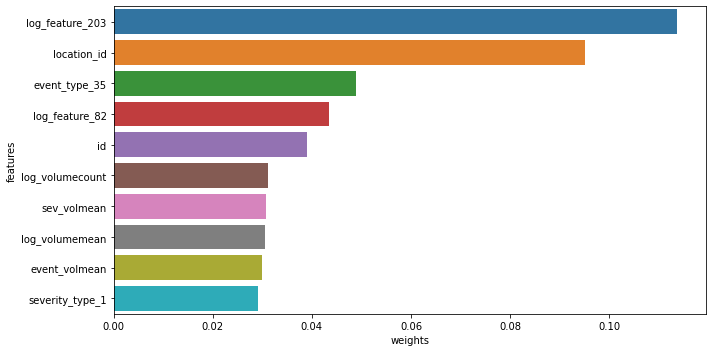

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x="weights",y="features",data=df_imp_features)
plt.tight_layout()
plt.savefig('rfc_importances2.png')

**Approach - 6 (OneHotEncoded + StdScaler + Added New Features)**

In [ ]:
# order ~ time
# ---------------------------------------------------------------------------------
severity_type_order = severity_type_copy[['id']].drop_duplicates()
severity_type_order['order'] = 1. * np.arange(len(severity_type_order)) / len(severity_type_order)

In [ ]:
X = pd.merge(left=X, right=severity_type_order, how='inner', on='id')
Y = pd.merge(left=Y, right=severity_type_order, how='inner', on='id')

In [ ]:
print(X.shape,Y.shape)

(7381, 475) (11171, 475)


In [ ]:
# rank location features by ascneding and descending orders
# ---------------------------------------------------------------------------------
X['location_rank_asc'] = X.groupby('location_id')[['order']].rank()
X['location_rank_desc'] = X.groupby('location_id')[['order']].rank(ascending=False)

# ---------------------------------------------------------------------------------
Y['location_rank_asc'] = Y.groupby('location_id')[['order']].rank()
Y['location_rank_desc'] = Y.groupby('location_id')[['order']].rank(ascending=False)

In [ ]:
print(X.shape,Y.shape)

(7381, 477) (11171, 477)


In [ ]:
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train,X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

In [ ]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

In [ ]:
# create a transformed for the numerical values
numeric_transformer_std = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler',StandardScaler())])

from sklearn.compose import ColumnTransformer

preprocessor_sca_std = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_std, numeric_features),
        #('cat', categorical_transformer, categorical_features)
    ])

In [ ]:
#We are then ready to transform!
X_train_transformed_sca1 = preprocessor_sca_minmax.fit_transform(X_train)
X_test_transformed_sca1 = preprocessor_sca_minmax.transform(X_test)
X_train_transformed_sca_copy = X_train_transformed_sca.copy()
test_transformed_sca1 = preprocessor_sca_minmax.transform(Y)

X_train_sca = pd.DataFrame(X_train_transformed_sca1)
X_test_sca = pd.DataFrame(X_test_transformed_sca1)
test_sca = pd.DataFrame(test_transformed_sca1)

In [ ]:
# Loop through classifiers
print('Model evaluation By Standardizing Data')

for classifier, clf_name in zip(classifiers, classifier_names):
  # Calculate CV
  print(clf_name,'\t',cross_val_score(estimator=classifier,X=X_train_sca, y=y_train, cv=5, scoring='f1_macro').mean())

Model evaluation By Standardizing Data
kNN 	 0.5952416662430791
forest 	 0.6787395827721161
LogReg 	 0.651336244617174
SVC 	 0.6313099716803015
XGB 	 0.6756731484016167
LGBM 	 0.7096398946040559


In [ ]:
lgbm = lgb.LGBMClassifier()
lgbm.fit(X_train_sca, y_train)

LGBMClassifier()

In [ ]:
#Predictions
y_pred = lgbm.predict(X_test_sca)
report9 = classification_report(y_test,y_pred,output_dict=True)
df_std = pd.DataFrame(report9).transpose()

In [ ]:
df_std

,precision,recall,f1-score,support
0,0.867735,0.904911,0.885934,957.000000
1,0.670659,0.597333,0.631876,375.000000
2,0.689655,0.689655,0.689655,145.000000
accuracy,0.805687,0.805687,0.805687,0.805687
macro avg,0.742683,0.730633,0.735822,1477.000000
weighted avg,0.800217,0.805687,0.802161,1477.000000


In [ ]:
loss2tr = log_loss(y_train.values, lgbm.predict_proba(X_train.values))
print("LGBM: train loss {:.4f}".format(loss2tr))
print('---------------------------------------------------------------')
loss2te = log_loss(y_test.values, lgbm.predict_proba(X_test.values))
print("LGBM: test loss {:.4f}".format(loss2te))

LGBM: train loss 1.1826
---------------------------------------------------------------
LGBM: test loss 1.1250


In [ ]:
predict_test = lgbm.predict_proba(test_sca)
pred_df = pd.DataFrame(predict_test,columns=['predict_0', 'predict_1', 'predict_2'])
Y3 = Y.reset_index()
results = pd.concat([Y3[['id']],pred_df],axis=1)
results = results.set_index('id')  # set ID as index
results.head()

,predict_0,predict_1,predict_2
id,,,
11066,0.976036,0.023333,0.000631
18000,0.409727,0.159216,0.431057
16964,0.990392,0.009123,0.000485
4795,0.643447,0.352071,0.004482
3392,0.316824,0.644197,0.038979


In [ ]:
results.to_csv('sub_lgbm_std.csv')

In [ ]:
features=[]
for columns in X.columns:
    features.append(columns)

In [ ]:
imp_features = lgbm.feature_importances_
for i in imp_features:
    print(i.round(3))
df_imp_features = pd.DataFrame({"features":features}).join(pd.DataFrame({"weights":imp_features}))
df_imp_features = df_imp_features.sort_values(by=['weights'], ascending=False)

831
829
0
0
0
0
0
0
0
0
0
0
24
0
17
11
30
0
32
0
13
29
6
6
0
0
12
0
0
0
4
0
0
0
17
76
0
0
0
0
0
0
14
1
0
0
0
0
0
0
0
0
0
0
34
31
63
0
0
0
0
9
58
5
0
75
32
0
71
0
425
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
13
0
0
0
0
17
0
0
1
0
0
0
25
0
0
42
31
9
0
0
0
0
0
8
0
0
0
0
0
50
0
52
44
0
95
19
19
0
0
0
0
30
14
7
0
0
0
0
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
13
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
47
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
6
0
0
0
0
0
0
47
36
0
0
0
0
0
0
0
2
0
25
15
0
0
0
0
0
0
0
0
5
0
29
0
17
0
11
5
0
0
40
31
127
9
0
0
10
0
12
0
6
0
0
0
0
0
0
0
14
0
22
10
39
0
0
0
7
2
2
11
0
39
13
8
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
23
0
0
0
0
0
0
0
0
0
5
0
0
0
0
0
22
2
26
0
0
0
0
0
0
0
0
0
5
0
0
0
10
10
15
11
6
1
0
39
17
15
36
4
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
14
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
0
0
0
0
0
0
0
0
0
0
0
0
2
0
0
0
0
0
0
0
0
0
0
0
305
209
414
253

In [ ]:
df_imp_features = df_imp_features.head(10)

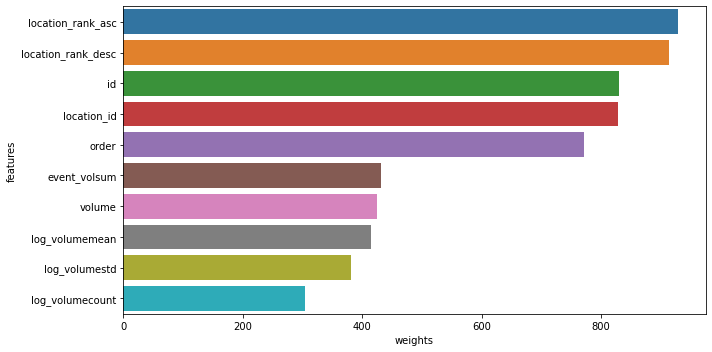

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x="weights",y="features",data=df_imp_features)
plt.tight_layout()
plt.savefig('lgbm_importances3.png')

**Approach - 7 (Target Encoding + Std Scaler + Adding new features)**



In [4]:
train_data = pd.read_csv('train.csv',index_col='id')
test_data = pd.read_csv('test.csv',index_col='id')
event_type = pd.read_csv('event_type.csv')
log_feature = pd.read_csv('log_feature.csv')
resource_type = pd.read_csv('resource_type.csv')
severity_type = pd.read_csv('severity_type.csv',index_col='id')

In [5]:
train_data_copy = pd.read_csv('train.csv',index_col='id')
test_data_copy = pd.read_csv('test.csv',index_col='id')
event_type_copy = event_type.copy()
log_feature_copy = log_feature.copy()
resource_type_copy = pd.read_csv('resource_type.csv')
severity_type_copy = pd.read_csv('severity_type.csv')

In [6]:
# append train & test
# ---------------------------------------------------------------------------------
train_data['location_id'] = train_data.location.apply(lambda x: int(x.split('location ')[1]))
test_data['location_id'] = test_data.location.apply(lambda x: int(x.split('location ')[1]))

print('train', train_data.shape, 'test', test_data.shape)

train (7381, 3) test (11171, 2)


In [7]:
#newly added
train_data['location_id'] = train_data.location.apply(lambda x: int(x.split('location ')[1]))
test_data['location_id'] = test_data.location.apply(lambda x: int(x.split('location ')[1]))

In [8]:
# order ~ time
# ---------------------------------------------------------------------------------
severity_type_order = severity_type_copy[['id']].drop_duplicates()
severity_type_order['order'] = 1. * np.arange(len(severity_type_order)) / len(severity_type_order)

In [9]:
severity_type_order.head(2)

,id,order
0,6597,0.000000
1,8011,0.000054


In [10]:
# merge all the features together
X_t = pd.merge(train_data,severity_type_order, how='left',left_index=True,right_index = True).fillna(0)
# merge all the features together
Y_t = pd.merge(test_data,severity_type_order, how='left',left_index=True,right_index = True).fillna(0)

In [11]:
# merge all the features together
X_t = pd.merge(X_t,severity_type,left_index=True,how='left',right_index = True).fillna(0)
# merge all the features together
Y_t = pd.merge(Y_t,severity_type,left_index=True,how='left',right_index = True).fillna(0)

In [12]:
print(X_t.shape,Y_t.shape)

(7381, 6) (11171, 5)


In [13]:
# merge event count
X_t = pd.merge(X_t, event_type, left_index=True,right_index = True, how='left').fillna(0)
Y_t = pd.merge(Y_t, event_type,left_index=True,right_index = True, how='left').fillna(0)

In [14]:
print(X_t.shape,Y_t.shape)

(7381, 8) (11171, 7)


In [15]:
# merge event count
X_t = pd.merge(X_t, log_feature, left_index=True,right_index = True, how='left').fillna(0)
Y_t = pd.merge(Y_t, log_feature,left_index=True,right_index = True, how='left').fillna(0)

In [16]:
print(X_t.shape,Y_t.shape)

(7381, 11) (11171, 10)


In [17]:
X_t = pd.merge(X_t,resource_type, right_index = True,left_index=True, how='left').fillna(0)
Y_t = pd.merge(Y_t,resource_type, right_index = True,left_index=True, how='left').fillna(0)

In [18]:
X_t.head(2)

,location,fault_severity,location_id,id_x,order,severity_type,id_y,event_type,id_x,log_feature,volume,id_y,resource_type
id,,,,,,,,,,,,,
14121,location 118,1,118,17133,0.761158,severity_type 2,6478,event_type 34,884,feature 44,2,9540,resource_type 2
9320,location 91,0,91,213,0.502372,severity_type 2,7252,event_type 35,8498,feature 227,4,13129,resource_type 2


In [19]:
# merge log features
log_vol = log_feature_copy.groupby('id')['volume'].agg(['count','min', 'mean', 'max', 'std', 'sum']).fillna(0).add_prefix('log_volume')

In [20]:
X_t = pd.merge(X_t,log_vol, right_index = True,left_index=True, how='left').fillna(0)
Y_t = pd.merge(Y_t,log_vol, right_index = True,left_index=True, how='left').fillna(0)

In [21]:
X_t.head(2)

,location,fault_severity,location_id,id_x,order,severity_type,id_y,event_type,id_x,log_feature,volume,id_y,resource_type,log_volumecount,log_volumemin,log_volumemean,log_volumemax,log_volumestd,log_volumesum
id,,,,,,,,,,,,,,,,,,,
14121,location 118,1,118,17133,0.761158,severity_type 2,6478,event_type 34,884,feature 44,2,9540,resource_type 2,2,19,19.0,19,0.00000,38
9320,location 91,0,91,213,0.502372,severity_type 2,7252,event_type 35,8498,feature 227,4,13129,resource_type 2,2,116,158.0,200,59.39697,316


In [22]:
print(X_t.shape,Y_t.shape)

(7381, 19) (11171, 18)


In [23]:
X11 = pd.merge(left=train_data_copy, right=event_type_copy, how='left', left_on='id', right_on='id')
Y11 = pd.merge(left=test_data_copy, right=event_type_copy, how='left', left_on='id', right_on='id')

In [24]:
X11 = pd.merge(left=X11, right=log_feature_copy, how='left', left_on='id', right_on='id')
Y11 = pd.merge(left=Y11, right=log_feature_copy, how='left', left_on='id', right_on='id')

In [25]:
# merge log features
events = X11.groupby('id')['volume'].agg(['count','min', 'mean', 'max','sum']).fillna(0).add_prefix('event_vol')

In [26]:
X_t = pd.merge(X_t,events, right_index = True,left_index=True, how='left').fillna(0)
Y_t = pd.merge(Y_t,events, right_index = True,left_index=True, how='left').fillna(0)

In [27]:
print(X_t.shape,Y_t.shape)

(7381, 24) (11171, 23)


In [28]:
X11 = pd.merge(left=X11, right=severity_type_copy, how='left', left_on='id', right_on='id')
Y11 = pd.merge(left=Y11, right=severity_type_copy, how='left', left_on='id', right_on='id')

In [29]:
# merge log features
severity = X11.groupby('id')['volume'].agg(['count','min', 'mean', 'max','sum']).fillna(0).add_prefix('sev_vol')

In [30]:
X_t = pd.merge(X_t,severity, right_index = True,left_index=True, how='left').fillna(0)
Y_t = pd.merge(Y_t,severity, right_index = True,left_index=True, how='left').fillna(0)

In [31]:
X11 = pd.merge(left=X11, right=resource_type_copy, how='left', left_on='id', right_on='id')
Y11 = pd.merge(left=Y11, right=resource_type_copy, how='left', left_on='id', right_on='id')

In [32]:
# merge log features
resource = X11.groupby('id')['volume'].agg(['count','min', 'mean', 'max','sum']).fillna(0).add_prefix('res_vol')

In [33]:
X_t = pd.merge(X_t,resource, right_index = True,left_index=True, how='left').fillna(0)
Y_t = pd.merge(Y_t,resource, right_index = True,left_index=True, how='left').fillna(0)

In [34]:
#newly added
X11['location_id'] = X11.location.apply(lambda x: int(x.split('location ')[1]))
Y11['location_id'] = Y11.location.apply(lambda x: int(x.split('location ')[1]))

In [35]:
X_t["avgvol_per_event"]= X11.groupby(['event_type'])["volume"].transform('mean')
X_t["maxvol_per_event"]= X11.groupby(['event_type'])["volume"].transform('max')
X_t["minvol_per_event"]= X11.groupby(['event_type'])["volume"].transform('mean')

Y_t["avgvol_per_event"]= Y11.groupby(['event_type'])["volume"].transform('mean')
Y_t["maxvol_per_event"]= Y11.groupby(['event_type'])["volume"].transform('max')
Y_t["minvol_per_event"]= Y11.groupby(['event_type'])["volume"].transform('mean')

In [36]:
X_t["avgvol_per_sev"]= X11.groupby(['severity_type'])["volume"].transform('mean')
X_t["maxvol_per_sev"]= X11.groupby(['severity_type'])["volume"].transform('max')
X_t["minvol_per_sev"]= X11.groupby(['severity_type'])["volume"].transform('mean')

Y_t["avgvol_per_sev"]= Y11.groupby(['severity_type'])["volume"].transform('mean')
Y_t["maxvol_per_sev"]= Y11.groupby(['severity_type'])["volume"].transform('max')
Y_t["minvol_per_sev"]= Y11.groupby(['severity_type'])["volume"].transform('mean')

In [37]:
print(X_t.shape,Y_t.shape)

(7381, 40) (11171, 39)


In [38]:
X_t.head(2)

,location,fault_severity,location_id,id_x,order,severity_type,id_y,event_type,id_x,log_feature,volume,id_y,resource_type,log_volumecount,log_volumemin,log_volumemean,log_volumemax,log_volumestd,log_volumesum,event_volcount,event_volmin,event_volmean,event_volmax,event_volsum,sev_volcount,sev_volmin,sev_volmean,sev_volmax,sev_volsum,res_volcount,res_volmin,res_volmean,res_volmax,res_volsum,avgvol_per_event,maxvol_per_event,minvol_per_event,avgvol_per_sev,maxvol_per_sev,minvol_per_sev
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
14121,location 118,1,118,17133,0.761158,severity_type 2,6478,event_type 34,884,feature 44,2,9540,resource_type 2,2,19,19.0,19,0.00000,38,4,19,19.0,19,76,4,19,19.0,19,76,4,19,19.0,19,76,7.479771,877,7.479771,7.103853,877,7.103853
9320,location 91,0,91,213,0.502372,severity_type 2,7252,event_type 35,8498,feature 227,4,13129,resource_type 2,2,116,158.0,200,59.39697,316,4,116,158.0,200,632,4,116,158.0,200,632,4,116,158.0,200,632,4.669983,154,4.669983,7.103853,877,7.103853


In [39]:
# Python log transform
X_t.insert(len(X_t.columns), 'log_volume',np.log(X_t['volume']))
Y_t.insert(len(Y_t.columns), 'log_volume',np.log(Y_t['volume']))

In [40]:
# rank features
# ---------------------------------------------------------------------------------
X_t['location_rank_asc'] = X_t.groupby('location_id')[['order']].rank()
X_t['location_rank_desc'] = X_t.groupby('location_id')[['order']].rank(ascending=False)

# ---------------------------------------------------------------------------------
Y_t['location_rank_asc'] = Y_t.groupby('location_id')[['order']].rank()
Y_t['location_rank_desc'] = Y_t.groupby('location_id')[['order']].rank(ascending=False)

In [41]:
print(X_t.shape,Y_t.shape)

(7381, 43) (11171, 42)


In [42]:
X_t.columns

Index(['location', 'fault_severity', 'location_id', 'id_x', 'order',
       'severity_type', 'id_y', 'event_type', 'id_x', 'log_feature', 'volume',
       'id_y', 'resource_type', 'log_volumecount', 'log_volumemin',
       'log_volumemean', 'log_volumemax', 'log_volumestd', 'log_volumesum',
       'event_volcount', 'event_volmin', 'event_volmean', 'event_volmax',
       'event_volsum', 'sev_volcount', 'sev_volmin', 'sev_volmean',
       'sev_volmax', 'sev_volsum', 'res_volcount', 'res_volmin', 'res_volmean',
       'res_volmax', 'res_volsum', 'avgvol_per_event', 'maxvol_per_event',
       'minvol_per_event', 'avgvol_per_sev', 'maxvol_per_sev',
       'minvol_per_sev', 'log_volume', 'location_rank_asc',
       'location_rank_desc'],
      dtype='object')

In [43]:
# Source: https://maxhalford.github.io/blog/target-encoding-done-the-right-way/
def calc_smooth_mean(df1, df2, cat_name, target, weight):

    # Compute the global mean
    mean = X_t[target].mean()

    # Compute the number of values and the mean of each group
    agg = X_t.groupby(cat_name)[target].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + weight * mean) / (counts + weight)

    # Replace each value by the according smoothed mean
    if df2 is None:
        return df1[cat_name].map(smooth)
    else:
        return df1[cat_name].map(smooth),df2[cat_name].map(smooth.to_dict())

In [44]:
WEIGHT = 10
X_t['loc_ord'] = calc_smooth_mean(df1=X_t, df2=None, cat_name='location', target='fault_severity', weight=WEIGHT)
Y_t['loc_ord'] = calc_smooth_mean(df1=X_t, df2=None, cat_name='location', target='fault_severity', weight=WEIGHT)

X_t['event_ord'] = calc_smooth_mean(df1=X_t, df2=None, cat_name='event_type', target='fault_severity', weight=WEIGHT)
Y_t['event_ord'] = calc_smooth_mean(df1=X_t, df2=None, cat_name='event_type', target='fault_severity', weight=WEIGHT)

X_t['res_ord'] = calc_smooth_mean(df1=X_t, df2=None, cat_name='resource_type', target='fault_severity', weight=WEIGHT)
Y_t['res_ord'] = calc_smooth_mean(df1=X_t, df2=None, cat_name='resource_type', target='fault_severity', weight=WEIGHT)

X_t['feature_ord'] = calc_smooth_mean(df1=X_t, df2=None, cat_name='log_feature', target='fault_severity', weight=WEIGHT)
Y_t['feature_ord'] = calc_smooth_mean(df1=X_t, df2=None, cat_name='log_feature', target='fault_severity', weight=WEIGHT)

In [45]:
X_t.columns

Index(['location', 'fault_severity', 'location_id', 'id_x', 'order',
       'severity_type', 'id_y', 'event_type', 'id_x', 'log_feature', 'volume',
       'id_y', 'resource_type', 'log_volumecount', 'log_volumemin',
       'log_volumemean', 'log_volumemax', 'log_volumestd', 'log_volumesum',
       'event_volcount', 'event_volmin', 'event_volmean', 'event_volmax',
       'event_volsum', 'sev_volcount', 'sev_volmin', 'sev_volmean',
       'sev_volmax', 'sev_volsum', 'res_volcount', 'res_volmin', 'res_volmean',
       'res_volmax', 'res_volsum', 'avgvol_per_event', 'maxvol_per_event',
       'minvol_per_event', 'avgvol_per_sev', 'maxvol_per_sev',
       'minvol_per_sev', 'log_volume', 'location_rank_asc',
       'location_rank_desc', 'loc_ord', 'event_ord', 'res_ord', 'feature_ord'],
      dtype='object')

In [46]:
X_t.head(2)

,location,fault_severity,location_id,id_x,order,severity_type,id_y,event_type,id_x,log_feature,volume,id_y,resource_type,log_volumecount,log_volumemin,log_volumemean,log_volumemax,log_volumestd,log_volumesum,event_volcount,event_volmin,event_volmean,event_volmax,event_volsum,sev_volcount,sev_volmin,sev_volmean,sev_volmax,sev_volsum,res_volcount,res_volmin,res_volmean,res_volmax,res_volsum,avgvol_per_event,maxvol_per_event,minvol_per_event,avgvol_per_sev,maxvol_per_sev,minvol_per_sev,log_volume,location_rank_asc,location_rank_desc,loc_ord,event_ord,res_ord,feature_ord
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
14121,location 118,1,118,17133,0.761158,severity_type 2,6478,event_type 34,884,feature 44,2,9540,resource_type 2,2,19,19.0,19,0.00000,38,4,19,19.0,19,76,4,19,19.0,19,76,4,19,19.0,19,76,7.479771,877,7.479771,7.103853,877,7.103853,0.693147,23.0,11.0,0.174467,0.461215,0.447191,0.365465
9320,location 91,0,91,213,0.502372,severity_type 2,7252,event_type 35,8498,feature 227,4,13129,resource_type 2,2,116,158.0,200,59.39697,316,4,116,158.0,200,632,4,116,158.0,200,632,4,116,158.0,200,632,4.669983,154,4.669983,7.103853,877,7.103853,1.386294,27.0,23.0,0.161053,0.438662,0.447191,0.456196


In [ ]:
"""
X_t =  X_t.drop(['id_x','id_y','location','event_type','resource_type_y','log_feature','severity_type'],axis=1)
Y_t = Y_t.drop(['id_x','id_y','location','event_type','resource_type','log_feature','severity_type'],axis=1)

"""

In [47]:
X_t.head(1)

,location,fault_severity,location_id,id_x,order,severity_type,id_y,event_type,id_x,log_feature,volume,id_y,resource_type,log_volumecount,log_volumemin,log_volumemean,log_volumemax,log_volumestd,log_volumesum,event_volcount,event_volmin,event_volmean,event_volmax,event_volsum,sev_volcount,sev_volmin,sev_volmean,sev_volmax,sev_volsum,res_volcount,res_volmin,res_volmean,res_volmax,res_volsum,avgvol_per_event,maxvol_per_event,minvol_per_event,avgvol_per_sev,maxvol_per_sev,minvol_per_sev,log_volume,location_rank_asc,location_rank_desc,loc_ord,event_ord,res_ord,feature_ord
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
14121,location 118,1,118,17133,0.761158,severity_type 2,6478,event_type 34,884,feature 44,2,9540,resource_type 2,2,19,19.0,19,0.0,38,4,19,19.0,19,76,4,19,19.0,19,76,4,19,19.0,19,76,7.479771,877,7.479771,7.103853,877,7.103853,0.693147,23.0,11.0,0.174467,0.461215,0.447191,0.365465


In [48]:
X_t =  X_t.drop(['id_x','id_y','location','event_type','severity_type','resource_type','log_feature'],axis=1)
Y_t = Y_t.drop(['id_x','id_y','location','event_type','severity_type','resource_type','log_feature'],axis=1)

In [49]:
X_t.reset_index(inplace=True)
Y_t.reset_index(inplace=True)

In [50]:
X_t.head(1)

,id,fault_severity,location_id,order,volume,log_volumecount,log_volumemin,log_volumemean,log_volumemax,log_volumestd,log_volumesum,event_volcount,event_volmin,event_volmean,event_volmax,event_volsum,sev_volcount,sev_volmin,sev_volmean,sev_volmax,sev_volsum,res_volcount,res_volmin,res_volmean,res_volmax,res_volsum,avgvol_per_event,maxvol_per_event,minvol_per_event,avgvol_per_sev,maxvol_per_sev,minvol_per_sev,log_volume,location_rank_asc,location_rank_desc,loc_ord,event_ord,res_ord,feature_ord
0,14121,1,118,0.761158,2,2,19,19.0,19,0.0,38,4,19,19.0,19,76,4,19,19.0,19,76,4,19,19.0,19,76,7.479771,877,7.479771,7.103853,877,7.103853,0.693147,23.0,11.0,0.174467,0.461215,0.447191,0.365465


In [51]:
index = Y_t['id']
Y_t['id'] = index

In [52]:
X_t = X_t.set_index('id')
Y_t = Y_t.set_index('id')

In [53]:
y_t = X_t['fault_severity']

In [54]:
X_t = X_t.drop(['fault_severity'], axis=1)
X_t.head(2)

,location_id,order,volume,log_volumecount,log_volumemin,log_volumemean,log_volumemax,log_volumestd,log_volumesum,event_volcount,event_volmin,event_volmean,event_volmax,event_volsum,sev_volcount,sev_volmin,sev_volmean,sev_volmax,sev_volsum,res_volcount,res_volmin,res_volmean,res_volmax,res_volsum,avgvol_per_event,maxvol_per_event,minvol_per_event,avgvol_per_sev,maxvol_per_sev,minvol_per_sev,log_volume,location_rank_asc,location_rank_desc,loc_ord,event_ord,res_ord,feature_ord
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
14121,118,0.761158,2,2,19,19.0,19,0.00000,38,4,19,19.0,19,76,4,19,19.0,19,76,4,19,19.0,19,76,7.479771,877,7.479771,7.103853,877,7.103853,0.693147,23.0,11.0,0.174467,0.461215,0.447191,0.365465
9320,91,0.502372,4,2,116,158.0,200,59.39697,316,4,116,158.0,200,632,4,116,158.0,200,632,4,116,158.0,200,632,4.669983,154,4.669983,7.103853,877,7.103853,1.386294,27.0,23.0,0.161053,0.438662,0.447191,0.456196


In [55]:
X2 = X_t.copy()
Y2 = Y_t.copy()

In [56]:
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train,X_test, y_train, y_test = train_test_split(X_t, y_t, stratify=y_t, test_size=0.2)

In [57]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(5904, 37) (5904,) (1477, 37) (1477,)


In [58]:
numeric_features = X_t.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_t.select_dtypes(include=['object', 'category']).columns

In [59]:
# import the needed libraries first
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

# create a transformer for the categorical values
#categorical_transformer = Pipeline(steps=[
 #   ('one_hot', OneHotEncoder())])

# create a transformed for the numerical values
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler',StandardScaler())])

In [60]:
from sklearn.compose import ColumnTransformer

preprocessor_sca_train = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        #('cat', categorical_transformer, categorical_features)
    ])

In [61]:
#We are then ready to transform!
X_train_transformed_sca = preprocessor_sca_train.fit_transform(X_train)
X_test_transformed_sca = preprocessor_sca_train.transform(X_test)
X_train_transformed_sca_copy = X_train_transformed_sca.copy()
test_transformed_sca = preprocessor_sca_train.transform(Y_t)

X_train_sca = pd.DataFrame(X_train_transformed_sca)
X_test_sca = pd.DataFrame(X_test_transformed_sca)
test_sca = pd.DataFrame(test_transformed_sca)

In [63]:
from sklearn.ensemble import GradientBoostingClassifier

In [64]:
classifiers = [KNeighborsClassifier(),
               RandomForestClassifier(),
               GaussianNB(),
               # Learn to predict each class against the other
               LogisticRegression(multi_class='ovr'),
               OneVsRestClassifier(SVC()),
               XGBClassifier(),
              GradientBoostingClassifier(),
               lgb.LGBMClassifier()
              ]
classifier_names = ['kNN','forest','GNB','LogReg','SVC','XGB','GBC','LGBM']

In [ ]:
# Loop through classifiers
print('Model evaluation By Standardizing Data')

for classifier, clf_name in zip(classifiers, classifier_names):
  # Calculate CV
  print(clf_name,'\t',cross_val_score(estimator=classifier,X=X_train_sca, y=y_train, cv=5, scoring='f1_macro').mean())

Model evaluation By Standardizing Data
kNN 	 0.5277020562508656
forest 	 0.6580928817952332
GNB 	 0.3408288948156314
LogReg 	 0.5584608787587345
SVC 	 0.5700220973358691
XGB 	 0.6774016106842854
GBC 	 0.6770275277900872
LGBM 	 0.6648074545494757


In [65]:
xgb = XGBClassifier()
xgb.fit(X_train_sca,y_train)

XGBClassifier(objective='multi:softprob')

In [66]:
#Predictions
y_pred = xgb.predict(X_test_sca)
report10 = classification_report(y_test,y_pred,output_dict=True)
df_std = pd.DataFrame(report10).transpose()

In [ ]:
df_std

,precision,recall,f1-score,support
0,0.838373,0.840125,0.839248,957.000000
1,0.623494,0.552000,0.585573,375.000000
2,0.516129,0.662069,0.580060,145.000000
accuracy,0.749492,0.749492,0.749492,0.749492
macro avg,0.659332,0.684731,0.668294,1477.000000
weighted avg,0.752182,0.749492,0.749397,1477.000000


In [68]:
X_train = X_train.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
y_train = y_train.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
X_test = X_test.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

In [ ]:
features=[]
for columns in X_t.columns:
    features.append(columns)

In [ ]:
imp_features = xgb.feature_importances_
for i in imp_features:
    print(i.round(3))
df_imp_features = pd.DataFrame({"features":features}).join(pd.DataFrame({"weights":imp_features}))
df_imp_features = df_imp_features.sort_values(by=['weights'], ascending=False)

0.025
0.017
0.011
0.066
0.101
0.024
0.015
0.037
0.098
0.084
0.0
0.0
0.0
0.03
0.0
0.0
0.0
0.0
0.0
0.026
0.0
0.0
0.0
0.023
0.018
0.013
0.0
0.016
0.014
0.0
0.0
0.03
0.027
0.275
0.014
0.009
0.025


In [ ]:
df_imp_features = df_imp_features.head(15)

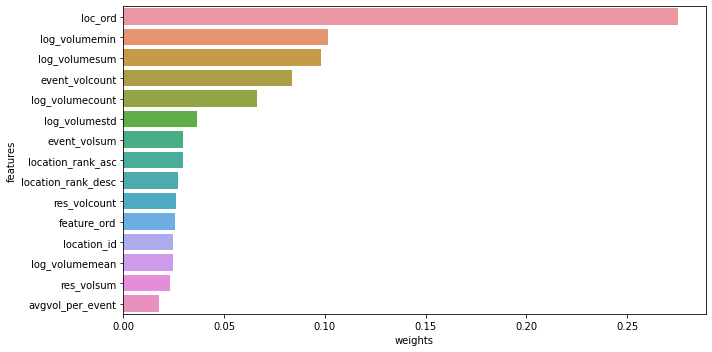

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x="weights",y="features",data=df_imp_features)
plt.tight_layout()
plt.savefig('lgbm_importances3.png')

In [ ]:
predict_test = gbc.predict_proba(test_sca)
pred_df = pd.DataFrame(predict_test,columns=['predict_0', 'predict_1', 'predict_2'])
Y3 = Y_t.reset_index()
results = pd.concat([Y3[['id']],pred_df],axis=1)
results = results.set_index('id')  # set ID as index
results.head()

In [ ]:
results.shape

In [ ]:
results.to_csv('sub_gbcw10.csv')

---------------------------------------------------------------------------------------------------------------------

In [ ]:
# create a transformed for the numerical values
from sklearn.preprocessing import MinMaxScaler
numeric_transformer_minmax = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler',MinMaxScaler())])

In [ ]:
from sklearn.compose import ColumnTransformer

preprocessor_sca_minmax = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_minmax, numeric_features),
        #('cat', categorical_transformer, categorical_features)
    ])

In [ ]:
#We are then ready to transform!
X_train_transformed_sca = preprocessor_sca_minmax.fit_transform(X_train)
X_test_transformed_sca = preprocessor_sca_minmax.transform(X_test)
X_train_transformed_sca_copy = X_train_transformed_sca.copy()
test_transformed_sca = preprocessor_sca_minmax.transform(Y_t)

X_train_sca = pd.DataFrame(X_train_transformed_sca)
X_test_sca = pd.DataFrame(X_test_transformed_sca)
test_sca = pd.DataFrame(test_transformed_sca)

In [ ]:
gbc = GradientBoostingClassifier()

gbc.fit(X_train_sca, y_train)

In [ ]:
#Predictions
y_pred = gbc.predict(X_test_sca)
report10 = classification_report(y_test,y_pred,output_dict=True)
df_std = pd.DataFrame(report10).transpose()

In [ ]:
df_std

In [ ]:
loss2tr = log_loss(y_train.values, gbc.predict_proba(X_train_sca.values))
print("Random forest: train loss {:.4f}".format(loss2tr))
print('---------------------------------------------------------------')
loss2te = log_loss(y_test.values, gbc.predict_proba(X_test_sca.values))
print("Random forest: test loss {:.4f}".format(loss2te))

In [ ]:
predict_test = gbc.predict_proba(test_sca)
pred_df = pd.DataFrame(predict_test,columns=['predict_0', 'predict_1', 'predict_2'])
Y3 = Y_t.reset_index()
results = pd.concat([Y3[['id']],pred_df],axis=1)
results = results.set_index('id')  # set ID as index
results.head()

In [ ]:
results.to_csv('sub_gbcw10_minmax.csv')

In [ ]:
print(X_t.shape,Y_t.shape)

Neural Network 

In [ ]:
# Classification neural network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X_t, y_t, test_size=0.2, random_state=42)

In [ ]:
#We are then ready to transform!
X_train_transformed_sca = preprocessor_sca_train.fit_transform(X_train)
X_test_transformed_sca = preprocessor_sca_train.transform(X_test)
X_train_transformed_sca_copy = X_train_transformed_sca.copy()
test_transformed_sca = preprocessor_sca_train.transform(Y_t)

X_train_sca = pd.DataFrame(X_train_transformed_sca)
X_test_sca = pd.DataFrame(X_test_transformed_sca)
test_sca = pd.DataFrame(test_transformed_sca)

In [ ]:
X_t.shape

In [ ]:
X_train_sca1 = X_train_sca.values
X_test_sca1 = X_test_sca.values

In [ ]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(23,)),
    keras.layers.Dense(16, activation=tf.nn.relu),
	keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.softmax),
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train_sca, y_train, epochs=50, batch_size=1)

test_loss, test_acc = model.evaluate(X_test_sca, y_test)
print('Test accuracy:', test_acc)


In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred2})
df